In [1]:
from foundry.util.runtime import setup
setup()

from image_diffusion.main import logger
logger.setLevel('INFO')

import foundry.random
import foundry.core.tree as tree
import foundry.numpy as npx
import foundry.train

from foundry.core.dataclasses import dataclass, replace

import foundry.core as F
import flax.linen as nn
import flax.linen.activation as activations

import rich
import jax
import optax
import foundry.train.console
import seaborn as sns
sns.set_theme()

import matplotlib.pyplot as plt
from typing import Sequence

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Deja Vu Serif"
    # "font.family": "Charter BT Roman"
})
# Use only the CPU for visualizations
# jax.config.update("jax_platform_name", "cpu")

print("Devices:", jax.devices())


Devices: [CudaDevice(id=0)]


In [2]:
import foundry.util.serialize
import wandb
api = wandb.Api()
artifact = api.artifact("dpfrommer-projects/image-diffusion-eval/evaluation:v44")
entries = list(artifact.files())
data_url = entries[-1]._attrs["directUrl"]
eval_data = foundry.util.serialize.load(data_url)
checkpoint_url = eval_data.checkpoint_uri
checkpoint = foundry.util.serialize.load(checkpoint_url)

In [3]:
model = checkpoint.config.create()
schedule = checkpoint.schedule
vars = checkpoint.vars
normalizer, train_data, test_data = checkpoint.create_data()
train_data = jax.vmap(normalizer.normalize)(train_data.as_pytree())
test_data = jax.vmap(normalizer.normalize)(test_data.as_pytree())
latents = test_data.cond

[14:49:05] INFO     image_diffusion - Learning T-SNE embedding...


In [4]:
color_map = {
    0: "#E52B50",
    1: "#9F2B68",
    2: "#3B7A57",
    3: "#3DDC84",
    4: "#FFBF00",
    5: "#915C83",
    6: "#008000",
    7: "#7FFFD4",
    8: "#E9D66B",
    9: "#007FFF",
}
def embed_scatter(ax, zs, labels, **kwargs):
    colors = [color_map[label.item()] for label in labels]
    ax.scatter(zs[:, 0], zs[:, 1], c=colors, s=5, **kwargs)

def map(f, batch_size=None):
    return lambda *x: jax.lax.map(lambda x: f(*x), x, batch_size=batch_size)

def smoothing_eval(xs, ys, vals, radius=1/32):
    x_min, x_max = npx.min(xs), npx.max(xs)
    y_min, y_max = npx.min(ys), npx.max(ys)
    x_bw, y_bw = (x_max - x_min)*radius, (y_max - y_min)*radius

    def eval(x, y):
        dists_sqr = (xs - x)**2/(x_bw**2) + (ys - y)**2/(y_bw**2)
        log_kernel = -dists_sqr
        log_kernel = log_kernel - jax.scipy.special.logsumexp(log_kernel)
        return npx.exp(jax.scipy.special.logsumexp(log_kernel, b=vals))
    return eval

def smoothed_colormesh(ax, eval, *, 
        x_min, x_max, y_min, y_max,
        val_clip=None, **kwargs):
    xs_high = npx.linspace(x_min, x_max, 256)
    ys_high = npx.linspace(y_min, y_max, 256)
    XS_high, YS_high = npx.meshgrid(xs_high, ys_high)
    vals_high = map(map(eval, batch_size=4), batch_size=4)(XS_high, YS_high)
    if val_clip is not None:
        vals_high = vals_high.clip(-val_clip, val_clip)
    # plt.scatter(xs, ys, c=vals, **kwargs)
    return ax.pcolormesh(xs_high, ys_high, vals_high, **kwargs, rasterized=True)

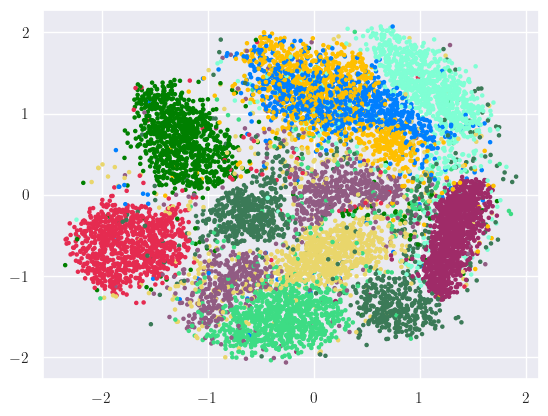

In [5]:
fig, ax = plt.subplots()
embed_scatter(ax, latents, test_data.label)
fig.show()

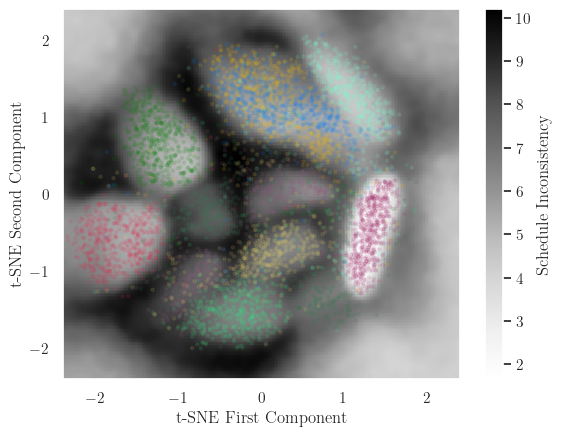

In [6]:
def heatmap(fig, ax, nw_error=True):
    mesh = smoothed_colormesh(ax,
        smoothing_eval(
            eval_data.cond[:,0], 
            eval_data.cond[:,1], 
            npx.mean(eval_data.nw_error if nw_error else eval_data.lin_error, -1),
            radius=1/64
        ),
        x_min=-2.4, x_max=2.4,
        y_min=-2.4, y_max=2.4,
        val_clip=12,
        cmap="Greys"
    )
    ax.set_ylim(-2.4, 2.4)
    ax.set_xlim(-2.4, 2.4)
    ax.set_xlabel("t-SNE First Component")
    ax.set_ylabel("t-SNE Second Component")
    cbar = fig.colorbar(mesh)

    if not nw_error:
        ax.scatter(eval_data.keypoints[:,0], eval_data.keypoints[:,1], color="red")

    if nw_error:
        cbar.set_label("Schedule Inconsistency")
    else:
        cbar.set_label("Error from Best Interpolant")
    embed_scatter(ax, latents[::2], test_data.label[::2], alpha=0.1)

fig, ax = plt.subplots()
heatmap(fig, ax)
fig.savefig("error_visualization.pdf", bbox_inches="tight")
fig.show()


[106.09857 109.14067 120.52192 ...  71.77365 102.13376  82.1393 ]


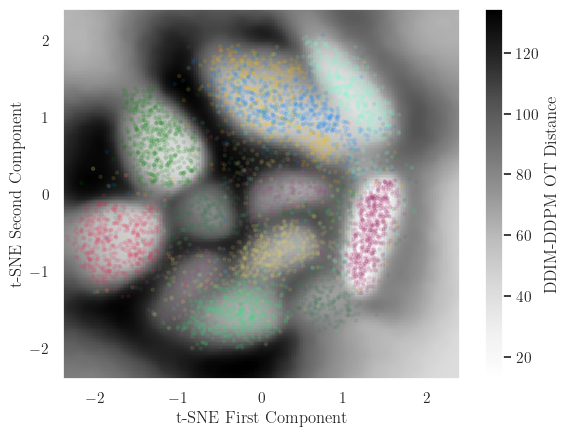

In [7]:
def transport_heatmap(fig, ax, nw_error=True):
    print(eval_data.ott_cost)
    mesh = smoothed_colormesh(ax,
        smoothing_eval(
            eval_data.cond[:,0], 
            eval_data.cond[:,1], 
            eval_data.ott_cost,
            radius=1/64
        ),
        x_min=-2.4, x_max=2.4,
        y_min=-2.4, y_max=2.4,
        cmap="Greys"
    )
    ax.set_ylim(-2.4, 2.4)
    ax.set_xlim(-2.4, 2.4)
    ax.set_xlabel("t-SNE First Component")
    ax.set_ylabel("t-SNE Second Component")
    cbar = fig.colorbar(mesh)

    cbar.set_label("DDIM-DDPM OT Distance")
    embed_scatter(ax, latents[::2], test_data.label[::2], alpha=0.1)

fig, ax = plt.subplots()
transport_heatmap(fig, ax)
fig.savefig("error_visualization.pdf", bbox_inches="tight")
fig.show()

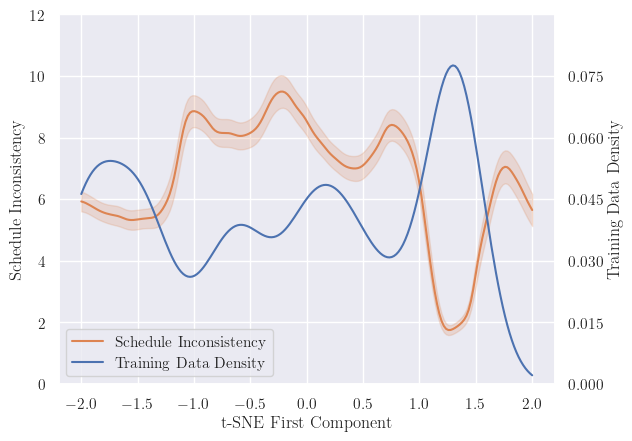

In [36]:
def latent_density(x):
    sigma = 0.2
    log_density = -npx.sum(npx.square(latents - x), axis=-1)/(2*sigma**2)
    N = log_density.shape[0]
    log_density = jax.scipy.special.logsumexp(log_density)
    log_norm = 1/2*npx.log(2*npx.pi) + npx.log(sigma) + npx.log(N)
    return npx.exp(log_density - log_norm)

def density_plot(ax1, nw_error=True):
    t = npx.linspace(-2, 2, 200)
    zs = npx.array([1, 0])[None,:]*t[:,None] + npx.array([[0, -0.5]])
    density = F.vmap(latent_density)(zs)
    nw_err = F.vmap(smoothing_eval(
        eval_data.cond[:,0], eval_data.cond[:,1], 
        npx.mean(eval_data.nw_error if nw_error else eval_data.lin_error, -1),
        radius=1/64,
    ))(zs[:,0], zs[:,1])
    nw_std = F.vmap(smoothing_eval(
        eval_data.cond[:,0], eval_data.cond[:,1], 
        npx.std(eval_data.nw_error if nw_error else eval_data.lin_error, -1),
        radius=1/64,
    ))(zs[:,0], zs[:,1]) / npx.sqrt(eval_data.nw_error.shape[-1])

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    ax1.set_xlabel("t-SNE First Component")

    h1, = ax1.plot(t, nw_err, color=colors[1], label="Schedule Inconsistency" if nw_error else "Error from Best Interpolant")
    ax1.fill_between(t, nw_err - nw_std, nw_err + nw_std, color=colors[1], alpha=0.2)
    if nw_error:
        ax1.set_ylabel("Schedule Inconsistency")
    else:
        ax1.set_ylabel("Error from Best Interpolant")

    ax2 = ax1.twinx()

    h2, = ax2.plot(t, density, color=colors[0], label="Training Data Density")
    ax2.set_ylabel("Training Data Density")

    ax2.grid(False)
    ax1.grid(True)

    if nw_error:
        ax1.set_ylim(0, 12)
        ax1.set_yticks(npx.linspace(0, 12, 7))
    else:
        ax1.set_ylim(0, 4)
        ax1.set_yticks(npx.linspace(0, 4, 7))
    ax2.set_yticks(npx.linspace(0, 0.09, 7))
    ax2.set_ylim(0, 0.09)
    ax1.tick_params(axis="y", left=False, right=False)
    ax2.tick_params(axis="y", left=False, right=False)
    ax2.yaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))

    ax2.legend(handles=[h1,h2], loc="lower left")

fig, ax = plt.subplots()
density_plot(ax)
fig.savefig("latents_slice.pdf", bbox_inches="tight")
fig.show()

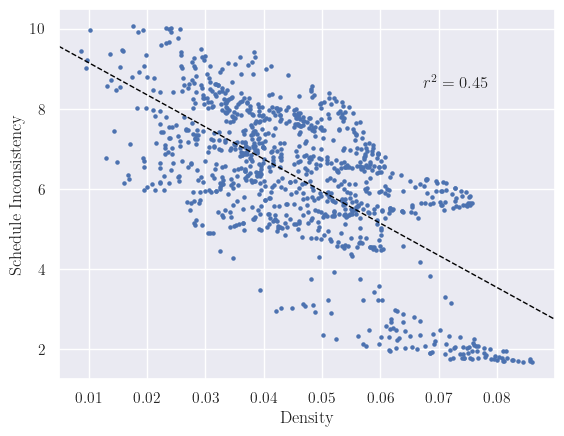

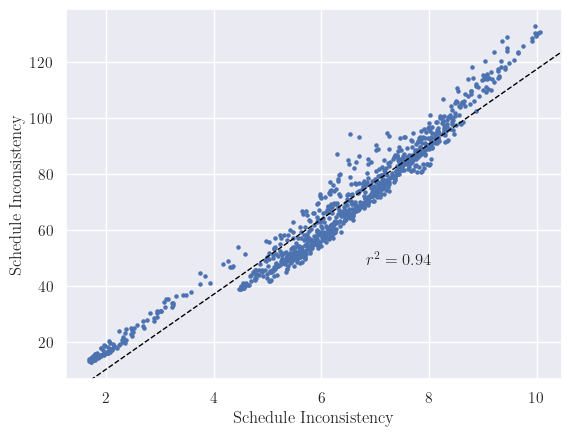

In [37]:
from sklearn.linear_model import LinearRegression
import sklearn.metrics

def density_scatter(ax, s=None, nw_error=True, ot_distance=False):
    Xs, Ys = latents[::10].T

    if ot_distance:
        y = F.vmap(smoothing_eval(
            eval_data.cond[:,0], 
            eval_data.cond[:,1], 
            eval_data.ott_cost,
            radius=1/64
            ))(Xs, Ys)
        x = F.vmap(smoothing_eval(
            eval_data.cond[:,0], 
            eval_data.cond[:,1], 
            (eval_data.nw_error if nw_error else eval_data.lin_error).mean(-1),
            radius=1/64
            ))(Xs, Ys)
        ax.set_xlabel("Schedule Inconsistency")
        if nw_error:
            ax.set_ylabel("Schedule Inconsistency")
        else:
            ax.set_ylabel("Error from Best Interpolant")
    else:
        x = F.vmap(latent_density)(npx.stack((Xs, Ys), -1))
        y = F.vmap(smoothing_eval(
            eval_data.cond[:,0], 
            eval_data.cond[:,1], 
            (eval_data.nw_error if nw_error else eval_data.lin_error).mean(-1),
            radius=1/64
            ))(Xs, Ys)
        ax.set_xlabel("Density")
        if nw_error:
            ax.set_ylabel("Schedule Inconsistency")
        else:
            ax.set_ylabel("Error from Best Interpolant")
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    y_pred = model.predict(x.reshape(-1, 1))
    r2 = sklearn.metrics.r2_score(y, y_pred)

    ax.scatter(x, y, s=s)

    x0, x1 = ax.get_xaxis().get_view_interval()
    y0, y1 = model.predict(((x0,),))[0], model.predict(((x1,),))[0]
    ax.add_line(plt.Line2D((x0, x1), (y0, y1), color="black", linestyle="--", linewidth=1))
    r2_loc = (0.67, 0.32) if ot_distance else (0.80, 0.80)
    ax.text(r2_loc[0], r2_loc[1], f"$r^2 = { r2 : 0.02}$", horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes)

fig, ax = plt.subplots()
density_scatter(ax, ot_distance=False, s=5)
fig.show()
fig, ax = plt.subplots()
density_scatter(ax, ot_distance=True, s=5)
fig.show()

[106.09857 109.14067 120.52192 ...  71.77365 102.13376  82.1393 ]


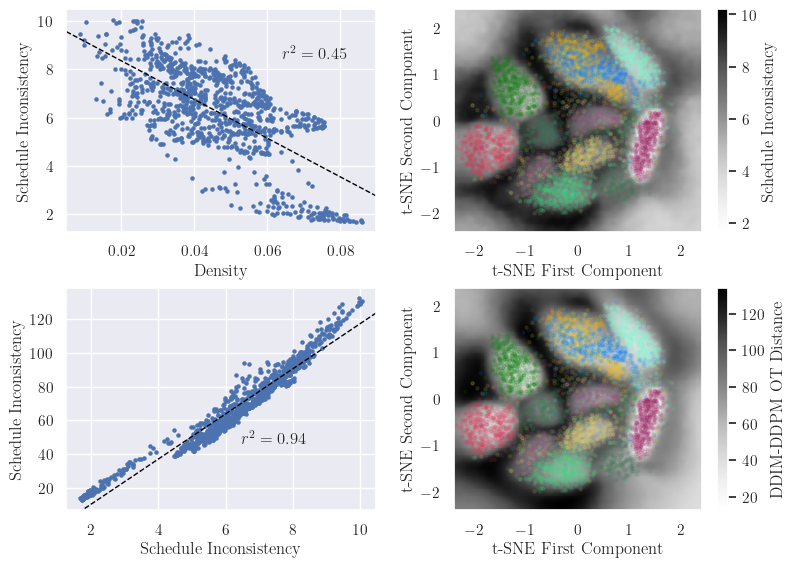

In [38]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 6.5))
heatmap(fig, ax2)
transport_heatmap(fig, ax4)
density_scatter(ax1, s=5)
density_scatter(ax3, s=5, ot_distance=True)
fig.subplots_adjust(wspace=0.25, hspace=0.25)
fig.savefig("combined.pdf", bbox_inches="tight", dpi=250)
fig.show()

In [39]:
# Load the historical evaluation data
artifact = api.artifact("dpfrommer-projects/image-diffusion-eval/evaluation:v36")
historical_data = list(a._attrs["directUrl"] for a in artifact.files())
historical_data = {int(e.split("/")[-1].split(".")[0]): foundry.util.serialize.load(e) for e in historical_data}

run = api.run("dpfrommer-projects/image-diffusion/runs/wbs0i39v")
training_loss_history = run.history(keys=["test/loss"])

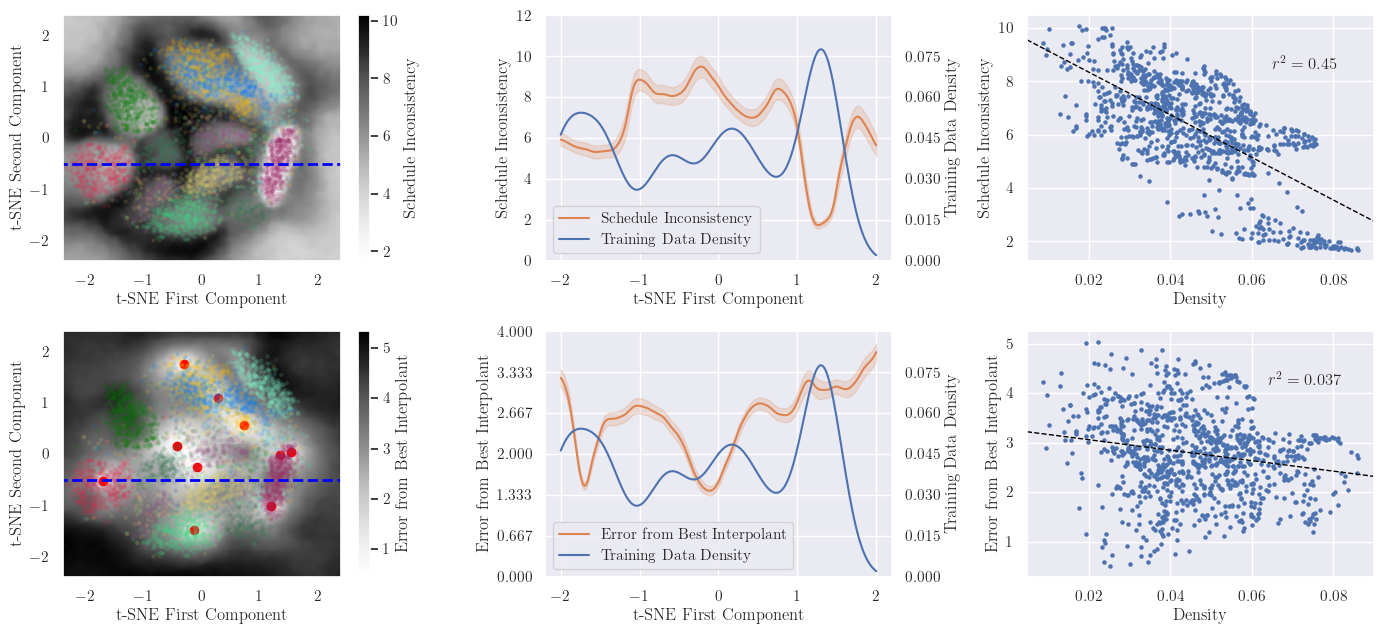

In [40]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14, 6.5))
heatmap(fig, ax1)
density_plot(ax2)
density_scatter(ax3, s=5)

heatmap(fig, ax4, nw_error=False)
density_plot(ax5, nw_error=False)
density_scatter(ax6, nw_error=False, s=5)

ax1.add_line(plt.Line2D((-2.5, 2.5), (-0.5, -0.5), color="blue", linestyle="--", linewidth=2))
ax4.add_line(plt.Line2D((-2.5, 2.5), (-0.5, -0.5), color="blue", linestyle="--", linewidth=2))

fig.tight_layout()
fig.savefig("combined.pdf", bbox_inches="tight", dpi=250)
fig.show()


In [ ]:
print(eval_data.cond[:,0].shape)